In [1]:
# use LSTM to classify sentiment
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D


In [2]:
df_train = pd.read_csv('train.tsv', sep='\t')
print('train set: {0}'.format(df_train.shape))
df_train.head(10)

train set: (156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [3]:
df_test = pd.read_csv('test.tsv', sep='\t')
print('test set: {0}'.format(df_test.shape))
df_test.head(10)

test set: (66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but
6,156067,8545,intermittently pleasing
7,156068,8545,intermittently
8,156069,8545,pleasing
9,156070,8545,but


In [4]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [5]:
X_train = df_train['Phrase'].apply(lambda p: clean_text(p))

max phrase len: 53


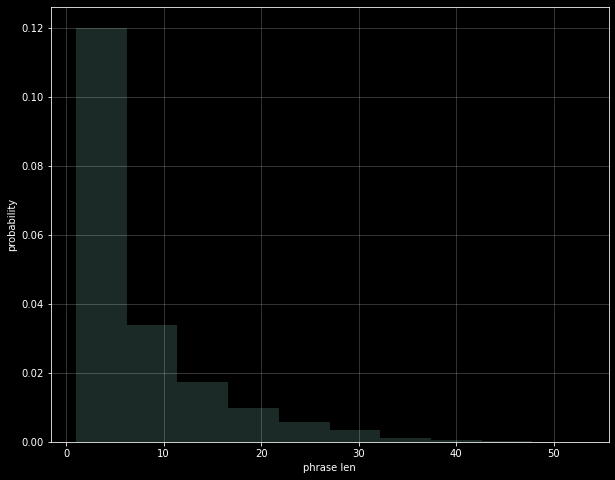

In [6]:
phrase_len = X_train.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
print('max phrase len: {0}'.format(max_phrase_len))
plt.figure(figsize = (10, 8))
plt.hist(phrase_len, alpha = 0.2, density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid(alpha = 0.25)

In [7]:
y_train = df_train['Sentiment']

In [8]:
max_words = 8192
tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = max_phrase_len)
y_train = to_categorical(y_train)

In [9]:
batch_size = 512
epochs = 8

In [10]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = max_words, output_dim = 256, input_length = max_phrase_len))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(256, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(5, activation = 'softmax'))
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)


In [11]:
history = model_lstm.fit(
    X_train,
    y_train,
    validation_split = 0.1,
    epochs = 8,
    batch_size = 512
)

Epoch 1/8
275/275 [==============================] - 233s 768ms/step - loss: 1.1899 - accuracy: 0.5343 - val_loss: 1.0202 - val_accuracy: 0.5946
Epoch 2/8
275/275 [==============================] - 243s 883ms/step - loss: 0.8497 - accuracy: 0.6598 - val_loss: 1.0045 - val_accuracy: 0.5999
Epoch 3/8
275/275 [==============================] - 271s 987ms/step - loss: 0.7923 - accuracy: 0.6814 - val_loss: 0.9941 - val_accuracy: 0.6056
Epoch 4/8
275/275 [==============================] - 305s 1s/step - loss: 0.7551 - accuracy: 0.6945 - val_loss: 1.0256 - val_accuracy: 0.6066
Epoch 5/8
275/275 [==============================] - 307s 1s/step - loss: 0.7267 - accuracy: 0.7030 - val_loss: 1.0343 - val_accuracy: 0.6073
Epoch 6/8
275/275 [==============================] - 338s 1s/step - loss: 0.7039 - accuracy: 0.7121 - val_loss: 1.0664 - val_accuracy: 0.6070
Epoch 7/8
275/275 [==============================] - 356s 1s/step - loss: 0.6821 - accuracy: 0.7194 - val_loss: 1.0873 - val_accuracy: 0.60

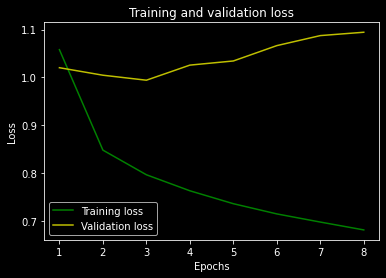

In [12]:
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
history

In [18]:
acc

[0.5799051523208618,
 0.6606504917144775,
 0.6794252991676331,
 0.6905463933944702,
 0.699851930141449,
 0.7068008184432983,
 0.7132299542427063,
 0.718562662601471]

In [20]:
val_acc = history.history['val_accuracy']

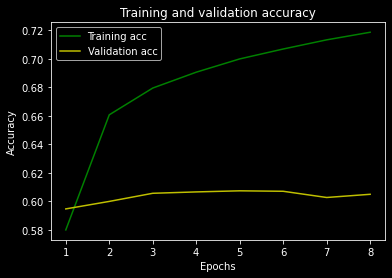

In [21]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
X_test = tokenizer.texts_to_sequences(['this is a terrible thing'])
x_test = pad_sequences(X_test, maxlen = max_phrase_len)
y_test=model_lstm.predict(x_test)
result  = np.argmax(y_test, axis=1)
print('The sentiment predicted', result+1)

X_test = tokenizer.texts_to_sequences(['this is good thing'])
x_test = pad_sequences(X_test, maxlen = max_phrase_len)
y_test=model_lstm.predict(x_test)
result  = np.argmax(y_test, axis=1)
print('The sentiment predicted', result+1)

The sentiment predicted [1]
The sentiment predicted [4]
